In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
import sklearn.preprocessing as preproc
from sklearn.cluster import KMeans, AgglomerativeClustering
from collections import Counter
from pract2_utils import *

In [2]:
RESULTS='results/accidentes/'
DATA='data/accidentes_2013.csv'

def readData(results_file):
    return pd.read_csv(results_file,header=0,engine='python')

In [3]:
dataTot=readData(DATA)
dataTot

,MES,HORA,DIASEMANA,PROVINCIA,COMUNIDAD_AUTONOMA,ISLA,TOT_VICTIMAS,TOT_VICTIMAS30D,TOT_MUERTOS,TOT_MUERTOS30D,...,PRIORIDAD,SUPERFICIE_CALZADA,LUMINOSIDAD,FACTORES_ATMOSFERICOS,VISIBILIDAD_RESTRINGIDA,OTRA_CIRCUNSTANCIA,ACERAS,TIPO_ACCIDENTE,DENSIDAD_CIRCULACION,MEDIDAS_ESPECIALES
0,8,14.0,3,Bizkaia,País Vasco,NO_ES_ISLA,3,3,0,0.054104,...,NINGUNA (SOLO NORMA),MOJADA,PLENO DÍA,LLUVIA FUERTE,FACTORES ATMOSFÉRICOS,OTRA,NO HAY ACERA,Colisión de vehículos en marcha (Frontal),FLUIDA,NINGUNA MEDIDA
1,6,18.0,6,Bizkaia,País Vasco,NO_ES_ISLA,1,1,0,0.000000,...,SEMÁFORO,MOJADA,PLENO DÍA,LLOVIZNANDO,OTRA_CAUSA,NINGUNA,NO HAY ACERA,Colisión de vehículos en marcha (Alcance),DENSA,NINGUNA MEDIDA
2,11,17.0,2,Tarragona,Cataluña,NO_ES_ISLA,2,2,0,0.000000,...,SEÑAL DE STOP,SECA Y LIMPIA,PLENO DÍA,BUEN TIEMPO,?,NINGUNA,NO HAY ACERA,Colisión de vehículos en marcha (Frontolateral),?,?
3,1,9.0,3,Lleida,Cataluña,NO_ES_ISLA,2,2,0,0.000000,...,?,MOJADA,PLENO DÍA,LLOVIZNANDO,?,NINGUNA,NO HAY ACERA,Colisión de vehículos en marcha (Múltiple o en...,?,NINGUNA MEDIDA
4,11,22.0,7,Barcelona,Cataluña,NO_ES_ISLA,2,2,0,0.000000,...,?,MOJADA,NOCHE: ILUMINACIÓN SUFICIENTE,LLUVIA FUERTE,?,NINGUNA,NO HAY ACERA,Colisión de vehículos en marcha (Frontolateral),?,?
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89514,6,19.0,5,Melilla,Ceuta y Melilla,NO_ES_ISLA,1,1,0,0.018035,...,NINGUNA (SOLO NORMA),SECA Y LIMPIA,PLENO DÍA,BUEN TIEMPO,SIN RESTRICCIÓN,NINGUNA,SI HAY ACERA,Atropello a peatón aislado o en grupo,FLUIDA,NINGUNA MEDIDA
89515,4,17.0,4,Melilla,Ceuta y Melilla,NO_ES_ISLA,1,1,0,0.000000,...,NINGUNA (SOLO NORMA),SECA Y LIMPIA,PLENO DÍA,BUEN TIEMPO,SIN RESTRICCIÓN,NINGUNA,SI HAY ACERA,Colisión de vehículos en marcha (Lateral),FLUIDA,NINGUNA MEDIDA
89516,1,23.0,5,Melilla,Ceuta y Melilla,NO_ES_ISLA,1,1,0,0.018035,...,SEÑAL DE CEDA EL PASO,SECA Y LIMPIA,NOCHE: ILUMINACIÓN SUFICIENTE,BUEN TIEMPO,SIN RESTRICCIÓN,NINGUNA,SI HAY ACERA,Colisión de vehículos en marcha (Frontolateral),FLUIDA,NINGUNA MEDIDA
89517,2,15.0,3,Melilla,Ceuta y Melilla,NO_ES_ISLA,2,2,0,0.000000,...,NINGUNA (SOLO NORMA),SECA Y LIMPIA,PLENO DÍA,BUEN TIEMPO,SIN RESTRICCIÓN,NINGUNA,SI HAY ACERA,Colisión de vehículos en marcha (Alcance),DENSA,NINGUNA MEDIDA


In [4]:
dataTot.columns

Index(['MES', 'HORA', 'DIASEMANA', 'PROVINCIA', 'COMUNIDAD_AUTONOMA', 'ISLA',
       'TOT_VICTIMAS', 'TOT_VICTIMAS30D', 'TOT_MUERTOS', 'TOT_MUERTOS30D',
       'TOT_HERIDOS_GRAVES', 'TOT_HERIDOS_GRAVES30D', 'TOT_HERIDOS_LEVES',
       'TOT_HERIDOS_LEVES30D', 'TOT_VEHICULOS_IMPLICADOS', 'ZONA',
       'ZONA_AGRUPADA', 'RED_CARRETERA', 'TIPO_VIA', 'TRAZADO_NO_INTERSEC',
       'TIPO_INTERSEC', 'ACOND_CALZADA', 'PRIORIDAD', 'SUPERFICIE_CALZADA',
       'LUMINOSIDAD', 'FACTORES_ATMOSFERICOS', 'VISIBILIDAD_RESTRINGIDA',
       'OTRA_CIRCUNSTANCIA', 'ACERAS', 'TIPO_ACCIDENTE',
       'DENSIDAD_CIRCULACION', 'MEDIDAS_ESPECIALES'],
      dtype='object')

In [5]:
# Atributos numéricos que reflejan la gravedad del accidente, sobre los que haré clustering
atributos=['TOT_VICTIMAS','TOT_MUERTOS','TOT_HERIDOS_GRAVES','TOT_HERIDOS_LEVES','TOT_VEHICULOS_IMPLICADOS']

## Caso de uso 1: Estudio de los accidentes en condiciones óptimas para la conducción

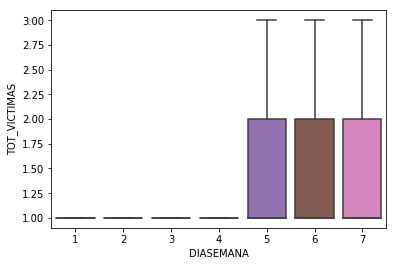

In [6]:
# Vemos que de lunes a jueves es más usual conducir sólo, puesto que la gente va al trabajo.
# La mayoría de accidentes (considera los otros como outliers) ocasionan una sola víctima
# En el fin de semana, es más usual conducir con más de una persona en el vehículo
sns.boxplot(data=dataTot,x='DIASEMANA', y='TOT_VICTIMAS', showfliers=False)

Filtramos los datos para quedarnos con accidentes en condiciones "óptimas" para la conducción.
Elegimos sólo accidentes que ocurren en sábado, para restringir el conjunto de datos (son demasiados y los algoritmos llevarían demasiado tiempo) pero manteniendo bastantes accidentes con más de un implicado.


In [7]:
Counter(dataTot.OTRA_CIRCUNSTANCIA)
#Counter(dataTot.MEDIDAS_ESPECIALES)

Counter({'?': 10130,
         'BACHES': 235,
         'BADEN': 99,
         'CAMBIO DE RASANTE': 279,
         'ESCALON': 33,
         'ESTRECHAMIENTO': 146,
         'FIN CARRIL LENTO': 17,
         'FIRME DESLIZANTE SEÑALIZADO': 57,
         'FUERTE DESCENSO': 691,
         'INUNDACIÓN': 50,
         'NINGUNA': 74719,
         'OBRAS': 457,
         'OTRA': 2556,
         'PASO A NIVEL': 29,
         'PERALTE INVERTIDO': 21})

In [8]:
data=dataTot[(dataTot.LUMINOSIDAD=='NOCHE: ILUMINACIÓN SUFICIENTE') | (dataTot.LUMINOSIDAD=='PLENO DÍA')]
data=data[data.DENSIDAD_CIRCULACION=='FLUIDA']
data=data[data.DIASEMANA==6]
data=data[data.OTRA_CIRCUNSTANCIA=='NINGUNA']
data=data[data.FACTORES_ATMOSFERICOS=='BUEN TIEMPO']
data=data[data.MEDIDAS_ESPECIALES=='NINGUNA MEDIDA']
data=data[data.SUPERFICIE_CALZADA=='SECA Y LIMPIA']
data=data[data.VISIBILIDAD_RESTRINGIDA=='SIN RESTRICCIÓN']
data=data[atributos]
data

,TOT_VICTIMAS,TOT_MUERTOS,TOT_HERIDOS_GRAVES,TOT_HERIDOS_LEVES,TOT_VEHICULOS_IMPLICADOS
17,4,0,2,2,3
188,1,1,0,0,1
212,1,0,1,0,2
258,5,2,2,1,2
280,1,0,1,0,2
...,...,...,...,...,...
89376,1,0,0,1,2
89396,1,0,0,1,2
89399,1,0,0,1,2
89410,1,0,0,1,2


In [9]:
# Algunas variables tienen valores extremos, que distorsionan las gráficas
for a in atributos:
    print(a)
    print(Counter(data[a]))

TOT_VICTIMAS
Counter({1: 2967, 2: 735, 3: 252, 4: 100, 5: 55, 6: 13, 7: 12, 8: 4, 10: 2, 18: 1, 52: 1, 9: 1})
TOT_MUERTOS
Counter({0: 4064, 1: 68, 2: 10, 4: 1})
TOT_HERIDOS_GRAVES
Counter({0: 3516, 1: 562, 2: 54, 3: 4, 5: 4, 4: 3})
TOT_HERIDOS_LEVES
Counter({1: 2587, 2: 630, 0: 531, 3: 238, 4: 91, 5: 39, 6: 12, 7: 8, 8: 3, 17: 1, 47: 1, 9: 1, 10: 1})
TOT_VEHICULOS_IMPLICADOS
Counter({2: 2192, 1: 1758, 3: 159, 4: 24, 5: 7, 9: 1, 6: 1, 7: 1})


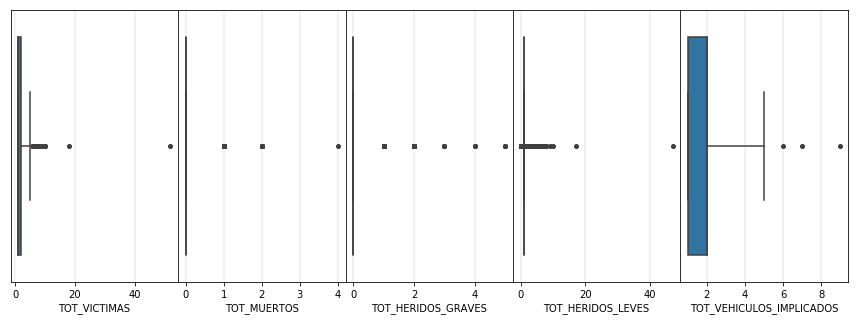

In [10]:
# Box Plot
n_var = len(atributos)
fig, axes = plt.subplots(1, n_var, sharey=True, figsize=(15,5))
fig.subplots_adjust(wspace=0, hspace=0)

colors = sns.color_palette(palette=None, n_colors=1, desat=None)

rango = []
for j in range(n_var):
    d=data[atributos[j]]
    rango.append([d.min(), d.max()])

for i in range(1):
    dat_filt = data
    for j in range(n_var):
        ax  = sns.boxplot(x=dat_filt[atributos[j]],
                         color=colors[i],
                         flierprops={
                             'marker': 'o',
                             'markersize': 4
                         },
                         ax=axes[j], whis=3,showfliers=True)

        if (i == 0):
            axes[j].set_xlabel(atributos[j])
        else:
            axes[j].set_xlabel("")

        if (j == 0):
            axes[j].set_ylabel("")
        else:
            axes[j].set_ylabel("")

        axes[j].set_yticks([])
        axes[j].grid(axis='x',
                        linestyle='-',
                        linewidth='0.2',
                        color='gray')
        axes[j].grid(axis='y', b=False)

        ax.set_xlim(rango[j][0] - 0.05 * (rango[j][1] - rango[j][0]),
                    rango[j][1] + 0.05 * (rango[j][1] - rango[j][0]))

In [11]:
# Eliminar outliers, ya que distorsionan las gráficas
for a in atributos:
    if a in {'TOT_MUERTOS','TOT_HERIDOS_GRAVES'}:
        continue
    d=data[a][abs(zscore(data[a]))<3]
    data[a][zscore(data[a])<-3]=d.min()
    data[a][zscore(data[a])>3]=d.max()

In [12]:
# Algunas variables tienen valores extremos, que distorsionan las gráficas
for a in atributos:
    print(a)
    print(Counter(data[a]))

TOT_VICTIMAS
Counter({1: 2967, 2: 735, 3: 252, 4: 100, 5: 89})
TOT_MUERTOS
Counter({0: 4064, 1: 68, 2: 10, 4: 1})
TOT_HERIDOS_GRAVES
Counter({0: 3516, 1: 562, 2: 54, 3: 4, 5: 4, 4: 3})
TOT_HERIDOS_LEVES
Counter({1: 2587, 2: 630, 0: 531, 3: 238, 4: 91, 5: 66})
TOT_VEHICULOS_IMPLICADOS
Counter({2: 2192, 1: 1758, 3: 193})


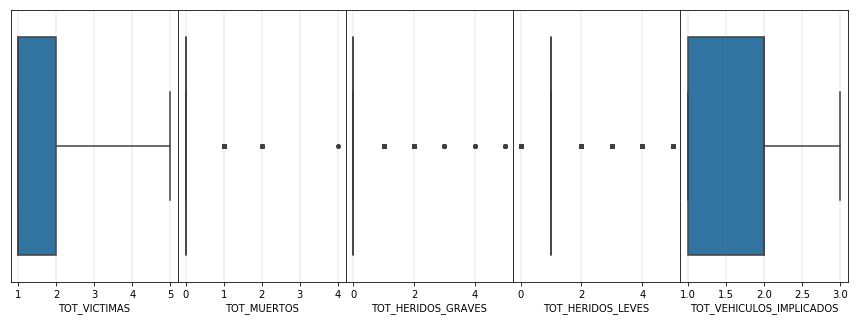

In [13]:
# Box Plot
n_var = len(atributos)
fig, axes = plt.subplots(1, n_var, sharey=True, figsize=(15,5))
fig.subplots_adjust(wspace=0, hspace=0)

colors = sns.color_palette(palette=None, n_colors=1, desat=None)

rango = []
for j in range(n_var):
    d=data[atributos[j]]
    #d=d[abs(zscore(d))<3]
    rango.append([d.min(), d.max()])

for i in range(1):
    dat_filt = data
    for j in range(n_var):
        ax  = sns.boxplot(x=dat_filt[atributos[j]],
                         color=colors[i],
                         flierprops={
                             'marker': 'o',
                             'markersize': 4
                         },
                         ax=axes[j], whis=3,showfliers=True)

        if (i == 0):
            axes[j].set_xlabel(atributos[j])
        else:
            axes[j].set_xlabel("")

        if (j == 0):
            axes[j].set_ylabel("")
        else:
            axes[j].set_ylabel("")

        axes[j].set_yticks([])
        axes[j].grid(axis='x',
                        linestyle='-',
                        linewidth='0.2',
                        color='gray')
        axes[j].grid(axis='y', b=False)

        ax.set_xlim(rango[j][0] - 0.05 * (rango[j][1] - rango[j][0]),
                    rango[j][1] + 0.05 * (rango[j][1] - rango[j][0]))

In [14]:
# Normalizar los datos
normalizer=preproc.MinMaxScaler()
data_norm=normalizer.fit_transform(data)
data_norm

array([[0.75, 0.  , 0.4 , 0.4 , 1.  ],
       [0.  , 0.25, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.2 , 0.  , 0.5 ],
       ...,
       [0.  , 0.  , 0.  , 0.2 , 0.5 ],
       [0.  , 0.  , 0.  , 0.2 , 0.5 ],
       [0.  , 0.  , 0.  , 0.2 , 0.5 ]])

### K-Means

In [15]:
# Elección de un número adecuado de Clústers atendiendo a las métricas
K=list(range(2,10))
silhouette=[]
calinski=[]
for k in K:
    results = KMeans(n_clusters=k, random_state=0).fit(data_norm)
    sil, cal = measures_silhoutte_calinski(data_norm, results.labels_)
    silhouette.append(sil)
    calinski.append(cal)

In [16]:
print(silhouette)
print(calinski)

[0.554135869926335, 0.6436774751523564, 0.6576903697140037, 0.6891979028078193, 0.7027316444530789, 0.7368975382285727, 0.7867435070579235, 0.8417025367184848]
[3042.32565654035, 4703.276490723743, 4136.87342581802, 4038.971966681051, 3853.2163277602067, 4151.423190642611, 4226.279512646909, 4805.497922282589]


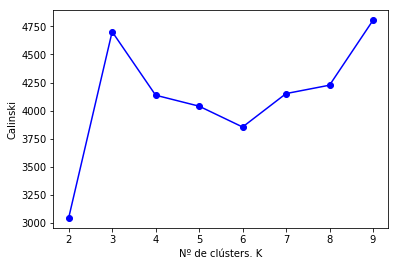

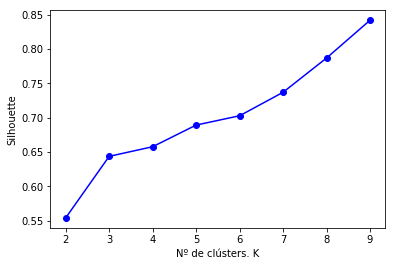

In [17]:
plt.plot(K,calinski, 'bo-')
plt.xlabel('Nº de clústers. K')
plt.ylabel('Calinski')
plt.show()
plt.plot(K,silhouette,'bo-')
plt.ylabel('Silhouette')
plt.xlabel('Nº de clústers. K')
plt.show()

Nos quedaremos con K=3. Introducir más clústers no gana tanto score y hace la segmentación muy difícil de interpretar.

In [18]:
K=3
results = KMeans(n_clusters=K, random_state=0).fit(data_norm)
labels=results.labels_
centroids=results.cluster_centers_

Análisis.

In [19]:
Counter(labels)

Counter({0: 419, 1: 1673, 2: 2051})

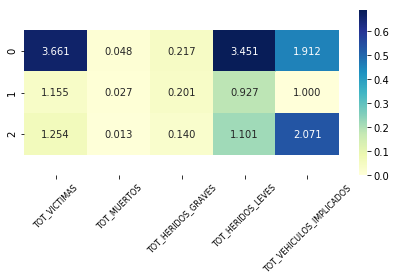

In [20]:
visualize_centroids(centroids, np.array(data), atributos, denormCentroids=True)

/home/dcabezas/.local/lib/python3.6/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


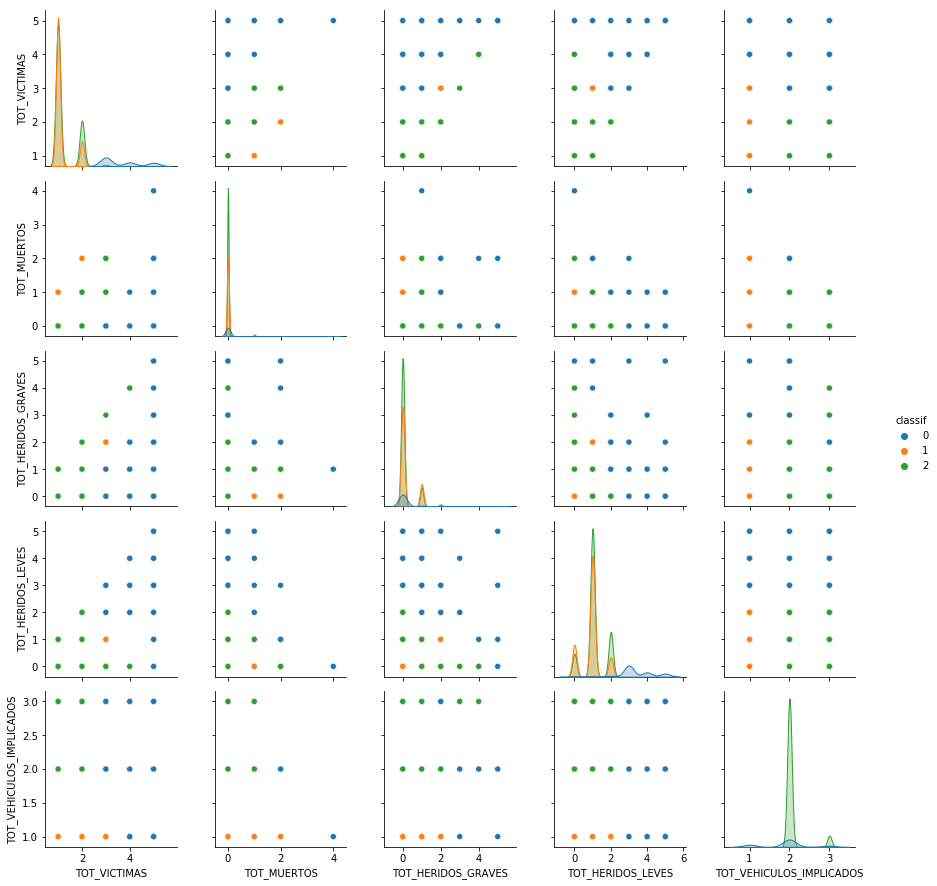

In [21]:
pairplot(data,atributos,labels)

In [22]:
dataC=data.copy()
dataC['cluster']=labels
dataC

,TOT_VICTIMAS,TOT_MUERTOS,TOT_HERIDOS_GRAVES,TOT_HERIDOS_LEVES,TOT_VEHICULOS_IMPLICADOS,cluster
17,4,0,2,2,3,0
188,1,1,0,0,1,1
212,1,0,1,0,2,2
258,5,2,2,1,2,0
280,1,0,1,0,2,2
...,...,...,...,...,...,...
89376,1,0,0,1,2,2
89396,1,0,0,1,2,2
89399,1,0,0,1,2,2
89410,1,0,0,1,2,2


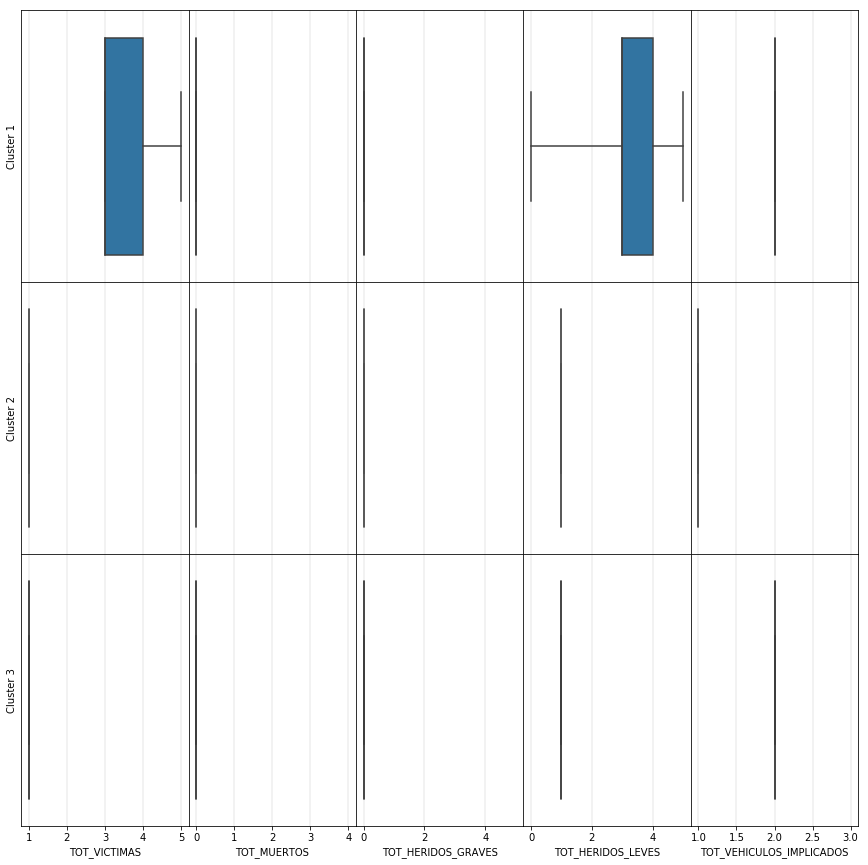

In [23]:
# Box Plot
n_var = len(atributos)
fig, axes = plt.subplots(K, n_var, sharey=True, figsize=(15, 15))
fig.subplots_adjust(wspace=0, hspace=0)

colors = sns.color_palette(palette=None, n_colors=K, desat=None)

rango = []
for j in range(n_var):
    d=dataC[atributos[j]]
    rango.append([d.min(), d.max()])

for i in range(K):
    dat_filt = dataC.loc[dataC['cluster'] == i]
    for j in range(n_var):
        ax  = sns.boxplot(x=dat_filt[atributos[j]],
                         color=colors[i],
                         flierprops={
                             'marker': 'o',
                             'markersize': 4
                         },
                         ax=axes[i, j], whis=3,showfliers=False)

        if (i == K - 1):
            axes[i, j].set_xlabel(atributos[j])
        else:
            axes[i, j].set_xlabel("")

        if (j == 0):
            axes[i, j].set_ylabel("Cluster " + str(i + 1))
        else:
            axes[i, j].set_ylabel("")

        axes[i, j].set_yticks([])
        axes[i, j].grid(axis='x',
                        linestyle='-',
                        linewidth='0.2',
                        color='gray')
        axes[i, j].grid(axis='y', b=False)

        ax.set_xlim(rango[j][0] - 0.05 * (rango[j][1] - rango[j][0]),
                    rango[j][1] + 0.05 * (rango[j][1] - rango[j][0]))

### Ward

Ahora utilizaremos un método aglomerativo para formar los clústers

In [24]:
# Elección de un umbral de distancia por encima del cual no se mezclarán más clústers
K=list(range(2,10))
silhouette=[]
calinski=[]
for k in K:
    results = AgglomerativeClustering(distance_threshold=None, n_clusters=k).fit(data_norm)
    sil, cal = measures_silhoutte_calinski(data_norm, results.labels_)
    silhouette.append(sil)
    calinski.append(cal)

In [25]:
print(silhouette)
print(calinski)

[0.553925286444123, 0.6001580718033601, 0.623619796307305, 0.6674109841636733, 0.715023098031553, 0.7540894010176521, 0.790530074272908, 0.8254082855580411]
[3038.939895342106, 3263.5006108555554, 3211.2214318407155, 3504.659880500535, 3925.906376649705, 3951.377474318098, 4090.581508592909, 4256.869613116355]


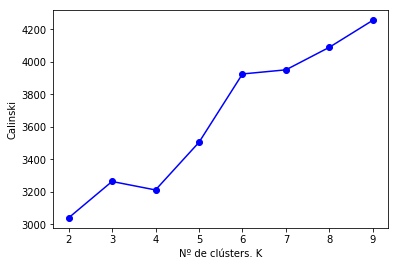

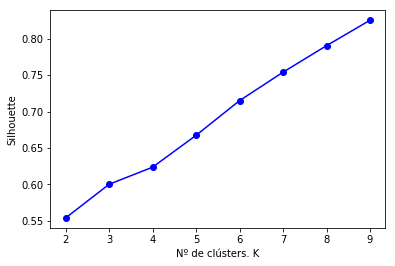

In [26]:
plt.plot(K,calinski, 'bo-')
plt.xlabel('Nº de clústers. K')
plt.ylabel('Calinski')
plt.show()
plt.plot(K,silhouette,'bo-')
plt.ylabel('Silhouette')
plt.xlabel('Nº de clústers. K')
plt.show()

La métrica Calinski nos sugiere utilizar K=6.

In [27]:
K=6
results = AgglomerativeClustering(distance_threshold=None, n_clusters=K).fit(data_norm)
labels=results.labels_

Calculamos los centroides a mano

In [28]:
dataC=data.copy()
dataC['cluster']=labels
dataC

,TOT_VICTIMAS,TOT_MUERTOS,TOT_HERIDOS_GRAVES,TOT_HERIDOS_LEVES,TOT_VEHICULOS_IMPLICADOS,cluster
17,4,0,2,2,3,1
188,1,1,0,0,1,0
212,1,0,1,0,2,2
258,5,2,2,1,2,1
280,1,0,1,0,2,2
...,...,...,...,...,...,...
89376,1,0,0,1,2,2
89396,1,0,0,1,2,2
89399,1,0,0,1,2,2
89410,1,0,0,1,2,2


In [29]:
centroids = dataC.groupby('cluster').mean()
centroids

,TOT_VICTIMAS,TOT_MUERTOS,TOT_HERIDOS_GRAVES,TOT_HERIDOS_LEVES,TOT_VEHICULOS_IMPLICADOS
cluster,,,,,
0,1.053583,0.030810,0.225050,0.797723,1.000000
1,2.351548,0.025501,0.078324,2.262295,2.005464
2,1.064495,0.015635,0.176547,0.872313,2.000000
3,4.478571,0.014286,0.150000,4.378571,2.192857
4,2.503788,0.011364,0.106061,2.409091,1.000000
5,1.555556,0.018519,0.092593,1.444444,3.000000


In [30]:
centroids=centroids.values
centroids

array([[1.05358339, 0.03081045, 0.22505023, 0.79772271, 1.        ],
       [2.35154827, 0.02550091, 0.07832423, 2.26229508, 2.00546448],
       [1.06449511, 0.01563518, 0.17654723, 0.8723127 , 2.        ],
       [4.47857143, 0.01428571, 0.15      , 4.37857143, 2.19285714],
       [2.50378788, 0.01136364, 0.10606061, 2.40909091, 1.        ],
       [1.55555556, 0.01851852, 0.09259259, 1.44444444, 3.        ]])

In [31]:
Counter(labels)

Counter({0: 1493, 1: 549, 2: 1535, 3: 140, 4: 264, 5: 162})

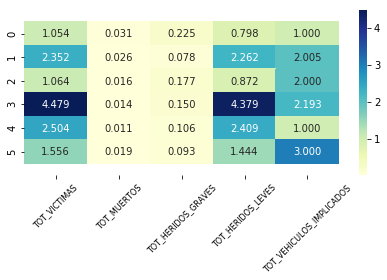

In [32]:
visualize_centroids(centroids, np.array(data), atributos, denormCentroids=False)

/home/dcabezas/.local/lib/python3.6/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/dcabezas/.local/lib/python3.6/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/dcabezas/.local/lib/python3.6/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/dcabezas/.local/lib/python3.6/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


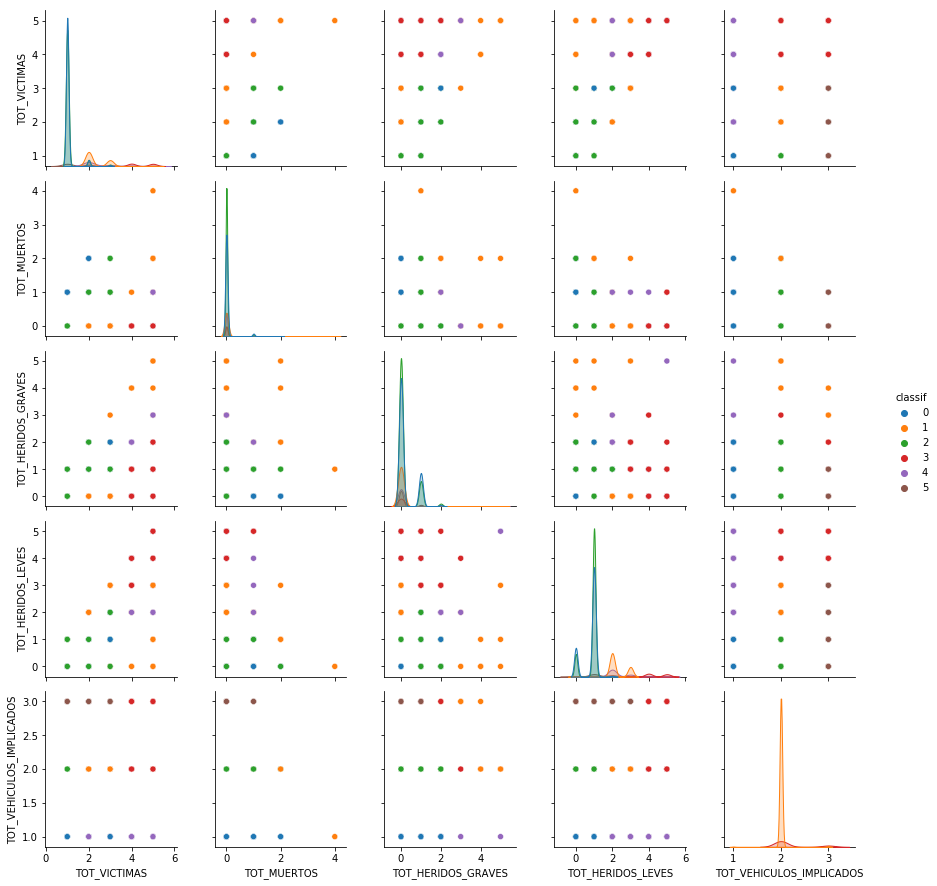

In [33]:
pairplot(data,atributos,labels)

In [34]:
dataC=data.copy()
dataC['cluster']=labels
dataC

,TOT_VICTIMAS,TOT_MUERTOS,TOT_HERIDOS_GRAVES,TOT_HERIDOS_LEVES,TOT_VEHICULOS_IMPLICADOS,cluster
17,4,0,2,2,3,1
188,1,1,0,0,1,0
212,1,0,1,0,2,2
258,5,2,2,1,2,1
280,1,0,1,0,2,2
...,...,...,...,...,...,...
89376,1,0,0,1,2,2
89396,1,0,0,1,2,2
89399,1,0,0,1,2,2
89410,1,0,0,1,2,2


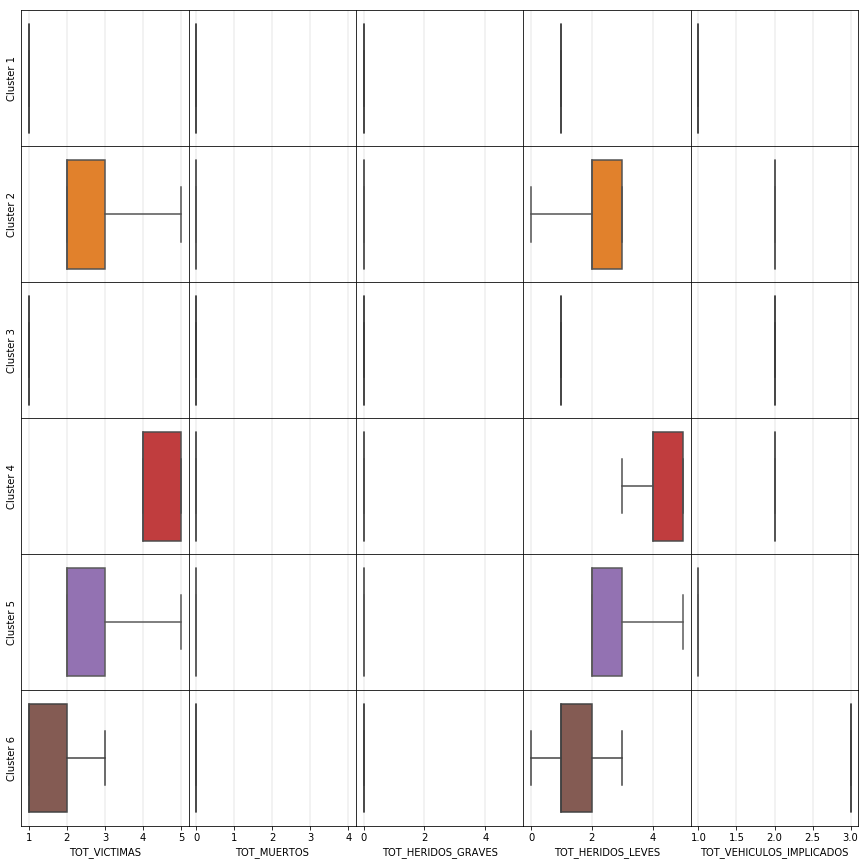

In [35]:
# Box Plot
n_var = len(atributos)
fig, axes = plt.subplots(K, n_var, sharey=True, figsize=(15, 15))
fig.subplots_adjust(wspace=0, hspace=0)

colors = sns.color_palette(palette=None, n_colors=K, desat=None)

rango = []
for j in range(n_var):
    d=dataC[atributos[j]]
    rango.append([d.min(), d.max()])

for i in range(K):
    dat_filt = dataC.loc[dataC['cluster'] == i]
    for j in range(n_var):
        ax  = sns.boxplot(x=dat_filt[atributos[j]],
                         color=colors[i],
                         flierprops={
                             'marker': 'o',
                             'markersize': 4
                         },
                         ax=axes[i, j], whis=3,showfliers=False)

        if (i == K - 1):
            axes[i, j].set_xlabel(atributos[j])
        else:
            axes[i, j].set_xlabel("")

        if (j == 0):
            axes[i, j].set_ylabel("Cluster " + str(i + 1))
        else:
            axes[i, j].set_ylabel("")

        axes[i, j].set_yticks([])
        axes[i, j].grid(axis='x',
                        linestyle='-',
                        linewidth='0.2',
                        color='gray')
        axes[i, j].grid(axis='y', b=False)

        ax.set_xlim(rango[j][0] - 0.05 * (rango[j][1] - rango[j][0]),
                    rango[j][1] + 0.05 * (rango[j][1] - rango[j][0]))

¿Por qué no agrupa por muertos y/o heridos graves?

In [36]:
print(sum(data.TOT_MUERTOS))
print(sum(data.TOT_HERIDOS_GRAVES))

92
714
